# Vsh striplog from log

This notebooks looks at the main `striplog` object. For the basic objects it depends on, see [Basic objects](./Basic_objects.ipynb).

First, import anything we might need.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import striplog
striplog.__version__

'0.7.0'

In [8]:
from striplog import Legend, Lexicon, Interval, Component

In [9]:
legend = Legend.builtin('NSDOE')
lexicon = Lexicon.default()

<hr />
## Making a `striplog`

In [13]:
from striplog import Striplog
imgfile = "data/images/M-MG-70_14.3_135.9.png"

In [14]:
strip = Striplog.from_image(imgfile, 14.3, 135.9, legend=legend)
strip

Striplog(26 Intervals, start=14.3, stop=135.9)

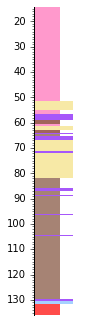

In [15]:
strip.plot(legend, ladder=True, aspect=3)

<hr />


## Striplogs from logs

We can read a log from an LAS file with `lasio`:

In [16]:
import lasio

Read a gamma-ray log.

In [18]:
l = lasio.read("data/las/P-129_out.LAS")
z, gr = l['DEPT'], l['GR']

In [19]:
z[-2000]

1634.49

Next we make a list of components to pass into the new striplog. The order must match the values you pass in the `to_log()` function:

In [20]:
comps = [Component({'lithology': 'sandstone'}),
         Component({'lithology': 'greywacke'}),
         Component({'lithology': 'shale'}), ]

Make a striplog from the GR curve, using the cutoffs given as `cutoff = [10, 50]`. These cutoffs define 3 lithologies, whichi is what we're passing in as `comps`. There must be enough components for the intervals you're defining.

If you don't provide `components`, you can provide `legend` instead; the components will be drawn from that. If you pass 'too many' components, they will be used in order and the 'extra' ones ignored.

You have to pass in the depth/elevation basis as well, because no assumptions are made about the log's extent.

In [21]:
s = Striplog.from_log(gr, cutoff=[10, 50], components=comps, basis=z)
s

Striplog(438 Intervals, start=1.0668, stop=1939.1376)

Now we can, say, remove the thin beds:

In [22]:
s.prune(limit=5)
s.anneal()
s

Striplog(78 Intervals, start=1.0668, stop=1939.1376)

And then read the log back into the intervals, 'reducing' with a function if we want:

In [23]:
s.extract(gr[2000:-2000], basis=z[2000:-2000], name='GR', function=np.mean)

In [24]:
s[20]

Interval({'top': Position({'middle': 647.8523999999999, 'units': 'm'}), 'description': '', 'data': {'GR': 82.48606672083919}, 'base': Position({'middle': 674.6747999999999, 'units': 'm'}), 'components': [Component({'lithology': 'shale'})]})

Now close the loop by exporting these values as a new log and comparing to the original. Since we reduced with `np.mean`, we will get a blocked log...

In [25]:
g, gz, _ = s.to_log(field="GR", start=500, stop=1500, return_meta=True)

In [26]:
g2, gz2, _ = s.to_log(field="GR", return_meta=True)

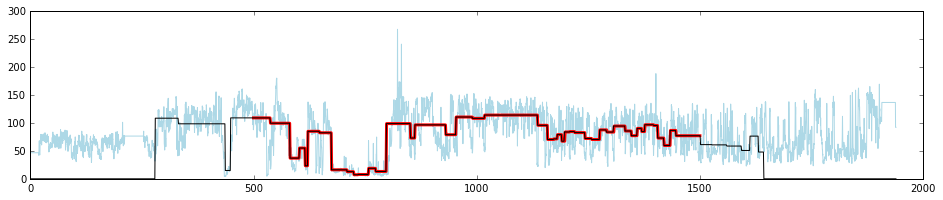

In [27]:
plt.figure(figsize=(16,3))
plt.plot(z, gr, color='lightblue')
plt.plot(gz, g, lw=3, color='red')
plt.plot(gz2, g2, lw=1, color='black')
plt.show()

## With a log transformation

In [28]:
def vsh(clean, shale):
    """
    Returns a function that computes mean VSH in the interval
    [0, 1], given GR values for clean sand and typical shale.
    """
    def _vsh(gr):
        mean = np.mean((gr - clean) / (shale - clean))
        return max(0.0, min(1.0, mean))
    return _vsh

In [29]:
s.extract(gr, basis=z, name='VSH', function=vsh(20, 80))

In [30]:
s[20]

Interval({'top': Position({'middle': 647.8523999999999, 'units': 'm'}), 'description': '', 'data': {'VSH': 1.0, 'GR': 82.48606672083919}, 'base': Position({'middle': 674.6747999999999, 'units': 'm'}), 'components': [Component({'lithology': 'shale'})]})

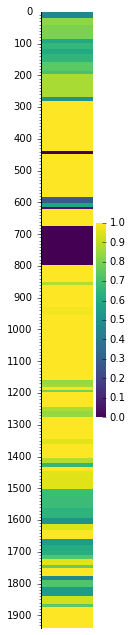

In [31]:
s.plot(aspect=6, colour='VSH')

<hr />

<p style="color:gray">©2015 Agile Geoscience. Licensed CC-BY. <a href="https://github.com/agile-geoscience/striplog">striplog.py</a></p>